# Build airport suitablity layers for GRIDCERF


The following code was used to build the airport suitability layers for GRIDCERF. GRIDCERF does not provide the source data directly due to some license restrictions related for direct redistribution of the unaltered source data.  However, the following details the provenance associated with each source dataset and how they were processed.


## 1. Setup environment

### 1.1 Download GRIDCERF

Download the GRIDCERF package if you have not yet done so from here:  https://doi.org/10.5281/zenodo.6601789.  Please extract GRIDCERF inside the `data` directory of this repository as the paths in this notebook are set to that expectation.


### 1.2 Data description


- **Title**:  U.S. Department of Transportation (USDOT) Bureau of Transportation Statistics (BTS) -  Airport Facilities
- **Description from Source**: The dataset provides users with information about airport locations and attributes and can be used for national and regional analysis applications.  The Aviation Facilities dataset is updated every 28 days from the Federal Aviation Administration (FAA) and is part of the U.S. Department of Transportation (USDOT)/Bureau of Transportation Statistics (BTS) National Transportation Atlas Database (NTAD). The Aviation Facilities dataset is a geographic point database of all official and operational aerodromes in the United States and U.S. Territories. Attribute data is provided on the physical and operational characteristics of the aerodrome, current usage including enplanements and aircraft operations, congestion levels and usage categories. This geospatial data is derived from the FAA's National Airspace System Resource Aeronautical Data Product. For more information about these data, please visit: https://www.faa.gov/air_traffic/flight_info/aeronav/Aero_Data/NASR_Subscription.
- **Source URL**:  https://geodata.bts.gov/datasets/usdot::aviation-facilities/explore
- **Date Accessed**:  7/20/23
- **Citation**
> Bureau of Transportation Statistics. Aviation Facilities. Transportation.gov U.S. Department of Transportation https://geodata.bts.gov/maps/usdot::aviation-facilities (2023).

-----

- **Title**:  U.S. Department of Transportation (USDOT) Bureau of Transportation Statistics (BTS) -  Runways
- **Description from Source**: This data provides users with information about the runway locations and attributes for national and regional analysis applications. The Runways dataset is updated every 28 days from the Federal Aviation Administration (FAA) and is part of the U.S. Department of Transportation (USDOT)/Bureau of Transportation Statistics (BTS) National Transportation Atlas Database (NTAD). The Runways database contains runways in the United States and US territories containing information on the physical characteristics of the runways. This data layer contains runways that have corresponding and reported runways ends, and the linear feature of the runway could be created based off these points. The runways in the dataset are associated with the airports dataset on NTAD, showing runways for all official and operational aerodromes. This geospatial data is derived from the FAA's National Airspace System Resource Aeronautical Data.
- **Source URL**:  https://geodata.bts.gov/datasets/usdot::runways/explore
- **Date Accessed**:  1/10/24
- **Citation**
> Bureau of Transportation Statistics. Runways. Transportation.gov U.S. Department of Transportation https://geodata.bts.gov/datasets/usdot::runways/explore (2023).

-------
**Application**:

According to Federal Aviation Administration DOT, 77.23 Standards for determining obstructions (https://www.govinfo.gov/content/pkg/CFR-2008-title14-vol2/pdf/CFR-2008-title14-vol2-sec77-23.pdf), any object that meets the following criteria is considered to be an aviation obstruction:
  
    "A height that is 200 feet above ground level or above the established airport elevation, whichever is higher, within 3 nautical miles of the established reference point of an airport, excluding heliports, with its longest runway more than 3,200 feet in actual length, and that height increases in the proportion of 100 feet for each additional nautical mile of distance from the airport up to a maximum of 500 feet."

The following buffer criteria, is therefore applied:

All airport, heliport, balloonport, and similar areas are excluded from siting for all technologies. For technologies that have facilities with tall components (e.g., wind turbines, CSP towers, plant stacks), an additional area around any airport that has a runway at least 3200 ft long is also excluded. Airports that do not meet this criteria receive no additional buffer. Heliports and baloonports do not receive an additional buffer. Power plant stacks which are part natural gas, coal, oil, and biomass facilities, are generally in the range of 500 to 700 ft tall (https://www.gao.gov/assets/gao-11-473.pdf), an average of 600ft is used within GRIDCERF. For solar CSP and cooling towers, values are used from NAS (2014). Wind farms receive a buffer calculated based on their hub height.

| Technology   | Height Assumption | Distance Required from Airports with runways > 2300ft long | 
|--------------|-------------------|----------------------------------------------------------- |
|wind          |80m                | 7km                                                    |
|wind          |100m               | 8km                                                    |
|wind          |120m               | 9km                                                    |
|wind          |140m               | 10km                                                   |
|wind          |160m               | 12km                                                   |
|Solar CSP     |540ft              | 12km                                                   |
|Plant stack   |600ft              | 13km                                                   |
|Cooling tower |370ft              | 9km                                                   |


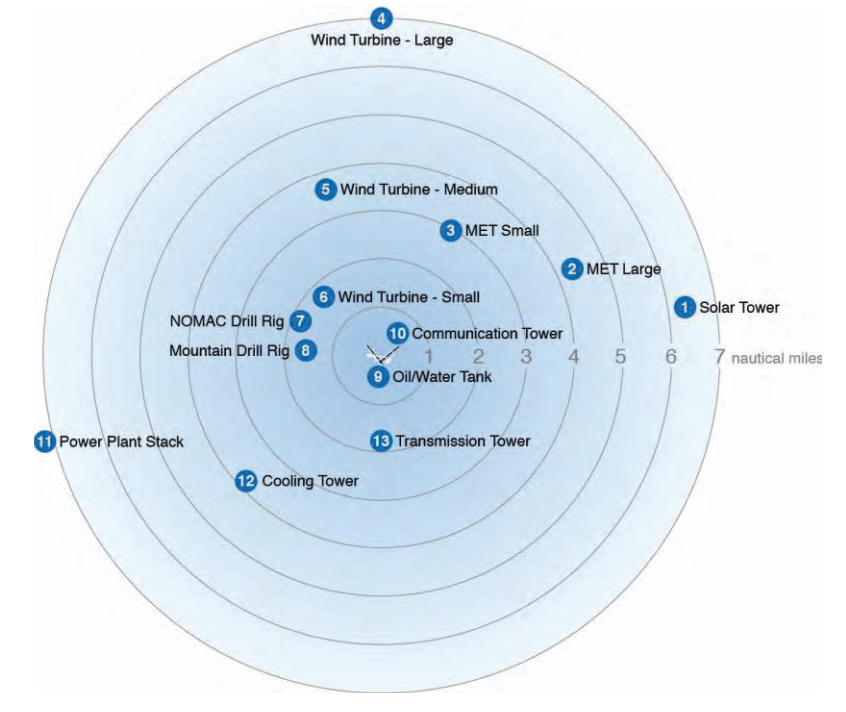

Image source: National Academies of Sciences, Engineering, and Medicine. 2014. Guidebook for Energy Facilities Compatibility with Airports and Airspace. Washington, DC:
The National Academies Press. https://doi.org/10.17226/22399.


### 1.3 Import modules


In [1]:
import os

import geopandas as gpd
import pandas as pd
import numpy as np
import rasterio
from rasterio import features
from rasterio.plot import show

## 2. Configuration


In [2]:
# get the parent directory path to where this notebook is currently stored
root_dir = os.path.dirname(os.getcwd())

# data directory in repository
data_dir = os.path.join(root_dir, "data")

# GRIDCERF data directory from downloaded archive
gridcerf_dir = os.path.join(data_dir, "gridcerf")

# GRIDCERF reference data directory
reference_dir = os.path.join(gridcerf_dir, "reference")

# GRIDCERF source data directory for the downloaded airport data
source_dir = os.path.join(gridcerf_dir, "source", "technology_specific", "usdot_airports")

# GRIDCERF technology_specific data directory
technology_specific_dir = os.path.join(gridcerf_dir, "technology_specific")

# GRIDCERF compiled final suitability data directory
compiled_dir = os.path.join(gridcerf_dir, "compiled")

# template siting mask raster
template_raster = os.path.join(reference_dir, "gridcerf_sitingmask.tif")

# CONUS boundary shapefile
conus_shpfile = os.path.join(reference_dir, "gridcerf_conus_boundary.shp")

# shapefile location for the source airports
airport_shpfile = os.path.join(source_dir, 'Aviation_Facilities', "Aviation_Facilities.shp")
runway_shpfile = os.path.join(source_dir, 'Runways', 'Runways.shp')

# create list of airport area buffers for various wind turbine hub heights
hub_height_m_list = [80, 100, 120, 140, 160]

# assumed CSP tower, power plant stack, and cooling tower heights
csp_tower_height_ft =540
power_stack_height_ft = 600
cooling_tower_height_fet = 370

## 4. Generate airport suitability rasters

### 4.1 Functions to build suitability

In [3]:
def vector_to_raster(template_raster, gdf, value_field, output_raster):
    """ Convert vector to raster"""
    # open the template raster and extract metadata and land mask
    with rasterio.open(template_raster) as template:

        metadata = template.meta.copy()

        # update raster data type
        metadata.update(dtype=np.int16)

        # extract land mask
        land_mask = template.read(1)
        land_mask = np.where(land_mask == 0, np.nan, 1)

        # write output raster
        with rasterio.open(output_raster, 'w+', **metadata) as out:

            out_arr = out.read(1)

            # build shapes to rasterize from target geometry and field
            shapes = ((geom, value) for geom, value in zip(gdf.geometry, gdf[value_field]))

            # burn features
            burned = features.rasterize(shapes=shapes, 
                                        fill=0, 
                                        out=out_arr, 
                                        transform=out.transform)
            
            burned = np.where(burned == 1, 1, 0).astype(np.float64)
            
            # apply land mask
            burned *= land_mask
            
            # make nan excluded
            burned = np.where(np.isnan(burned), 1, burned)

            out.write_band(1, burned.astype(np.int16))

def feet_to_meters(ft):
    """ convert feet to meters"""
    return ft*0.3048
    
def meters_to_feet(m):
    """ convert meters to feet"""
    return m*3.28084
    
def nautical_mi_mi(nm):
    """ convert nautical miles to miles"""
    return nm*1.15078
    
def mi_to_km(mi):
    """ convert miles to kilometers"""
    return mi*1.60934

def calculate_buffer_distance_km(height, meters=False):
    """ Calculates the buffer distance in km based on the height of an object. If an object is less than 200 ft high, there are no
    additional buffer restrictions. Any object over 200 ft must adhere to a buffer proportional to its height where a 200ft object 
    must be 3 nautical miles away from the airport boundary and for each additional 100 ft in height, an additional nautical mile
    is added to the distance it must be. 
    :param height:        height of the object
    :type height:         float
    :param meters:        if true, the height parameter supplied is in meters. If false, the height parameter is assumed to be in ft.
    :type meters:         bool

    :return:             buffer distance in km
    """
    # convert to feet if necessary
    if meters:
        height_ft = meters_to_feet(height)
    else:
        height_ft = height

    # calculate buffer
    if height_ft >= 200:
        ht_diff = height_ft - 200
        buffer = round(mi_to_km(nautical_mi_mi(3 + ht_diff/100)), 0)
    else:
        buffer = 0
        
    return buffer
    

### 4.2 Generate suitability

In [4]:
# read in GRIDCERF boundary shapefile
bdf = gpd.read_file(conus_shpfile)

In [5]:
# read in airports shapefile and project to our GRIDCERF projection
gdf_airports= gpd.read_file(airport_shpfile)[["OBJECTID", "geometry"]].to_crs(bdf.crs)

# read in runways shapefile and project to our GRIDCERF projection
gdf_runways= gpd.read_file(runway_shpfile)[["OBJECTID", 'RWY_LEN', "geometry"]].to_crs(bdf.crs)

In [6]:
# only keep airports within our GRIDCERF boundary
gdf_airports = gpd.clip(gdf_airports, bdf)

# add field to use for rasterization
gdf_airports["value"] = 1

# only keep runways within our GRIDCERF boundary
gdf_runways = gpd.clip(gdf_runways, bdf)

# add field to use for rasterization
gdf_runways["value"] = 1

#### 4.2.1 No Buffer Airport Layer

<Axes: >

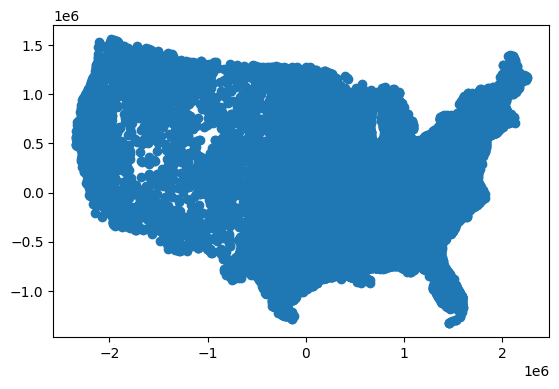

In [7]:
# combine airport point data with airport runway data, no buffer
airports_no_buffer = pd.concat([gdf_airports, gdf_runways])
airports_no_buffer = gpd.GeoDataFrame(airports_no_buffer, geometry="geometry", crs='ESRI:102003')
airports_no_buffer.plot()

In [8]:
output_nobuffer_file = os.path.join(technology_specific_dir, "gridcerf_airports_faa_no_buffer_conus.tif")

# generate raster for no buffer, all airports
vector_to_raster(template_raster, 
                 airports_no_buffer, 
                 "value",
                 output_nobuffer_file)

#### 4.2.2 Create Buffered Airport Layers

##### Determine buffer layers needed

In [9]:
# wind turbine buffer layers
buffer_layer_list = []
for meter_size in hub_height_m_list:
    buffer = calculate_buffer_distance_km(meter_size, meters=True)
    buffer_layer_list.append(buffer)

# CSP tower
csp_buffer = calculate_buffer_distance_km(csp_tower_height_ft, meters=False)
buffer_layer_list.append(csp_buffer)

# Power plant stack
stack_buffer = calculate_buffer_distance_km(power_stack_height_ft, meters=False)
buffer_layer_list.append(stack_buffer)

# cooling tower
cooling_tower = calculate_buffer_distance_km(cooling_tower_height_fet, meters=False)
buffer_layer_list.append(cooling_tower)

# get a unique list of ranges to create layers for
buffer_layer_list = list(set(buffer_layer_list))

buffer_layer_list

[7.0, 8.0, 9.0, 10.0, 12.0, 13.0]

In [10]:
# collect airports with runways greater than 3200 ft
gdf_over_3200 = gdf_runways[gdf_runways.RWY_LEN >= 3200]

Buffer: 7 km complete


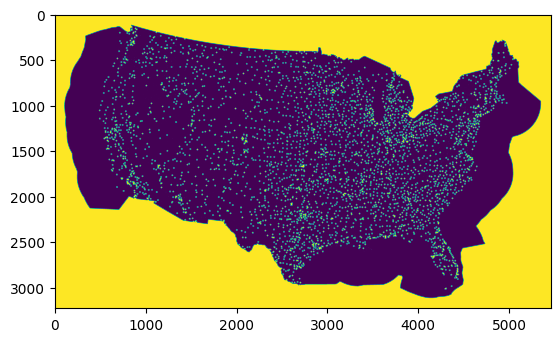

Buffer: 8 km complete


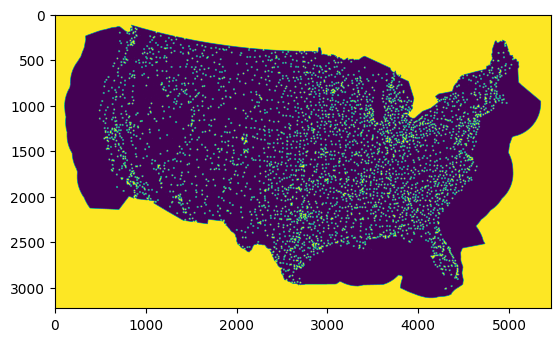

Buffer: 9 km complete


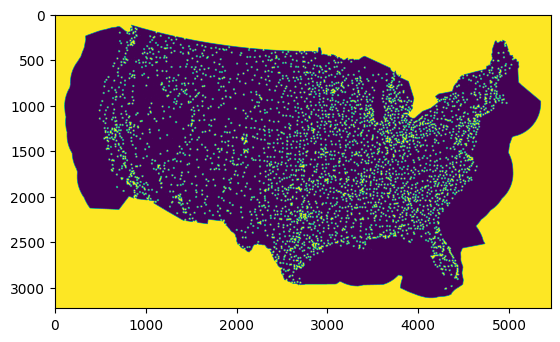

Buffer: 10 km complete


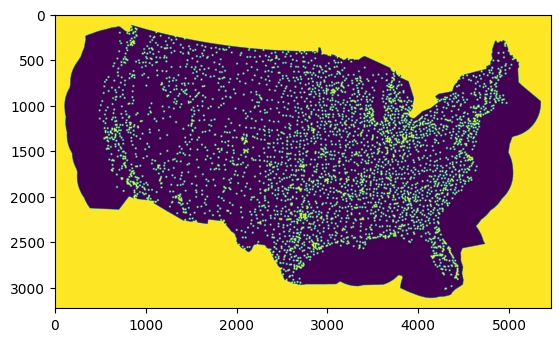

Buffer: 12 km complete


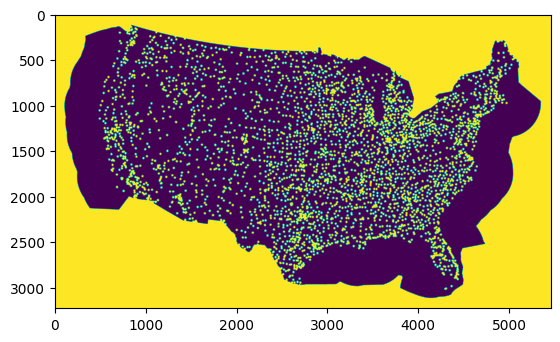

Buffer: 13 km complete


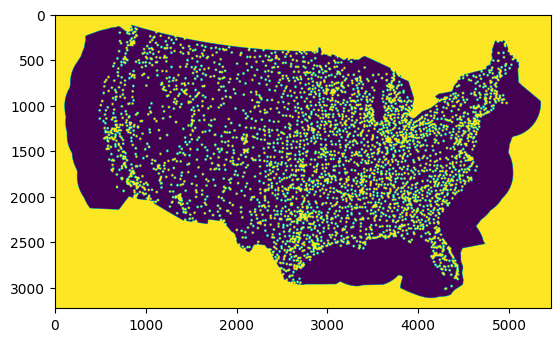

In [11]:
for buffer in buffer_layer_list:

    # convert buffer distance to an integer
    buffer = int(buffer)

    # buffer the runway for each distance in buffer list
    gdf_over_3200_buffer = gdf_over_3200.copy()
    gdf_over_3200_buffer.geometry = gdf_over_3200_buffer.geometry.buffer(buffer*1000, cap_style=3)

    # combine with no buffer geodataframe to also exclude small runway and non-airport (e.g., heliport) areas as is with no buffer on those areas
    gdf_buffer = pd.concat([airports_no_buffer, gdf_over_3200_buffer])
    gdf_buffer = gpd.GeoDataFrame(gdf_buffer, geometry="geometry", crs='ESRI:102003')
    
    output_file = os.path.join(technology_specific_dir, f"gridcerf_airports_faa_{buffer}km_buffer_conus.tif")
    
    # generate raster for no buffer, all airports
    vector_to_raster(template_raster, 
                     gdf_buffer, 
                     "value",
                     output_file)
    print(f'Buffer: {buffer} km complete')
    show(rasterio.open(output_file).read(1))